### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [334]:
from scipy.stats import randint as randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold
from multiprocessing.dummy import Pool as ThreadPool
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from collections import defaultdict
from collections import namedtuple
from collections import deque

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

In [168]:
EPSILON = 1e-15

class MyDecisionTreeClassifier(BaseEstimator):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1
    
    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.criterion = criterion

        if criterion  == "entropy":
            self._impurity_func = self._entropy
        elif criterion  == "gini":
            self._impurity_func = self._gini
        elif criterion  == "misclf":
            self._impurity_func = self._misclf
        else:
            raise ValueError(f"criterion '{criterion}' is not recognized")
            
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
    
    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold_by_feature_id(self, x, y):
        sorted_idx = x.argsort()
        x_s, y_s = x[sorted_idx], y[sorted_idx]

        ths, splits = np.unique(x_s, return_index=True)
        y_l = np.zeros((splits.shape[0], self.num_class))
        y_r = np.zeros((splits.shape[0], self.num_class))
        for i in range(splits.shape[0]):
            y_l[i] = np.bincount(y_s[:splits[i]], minlength=self.num_class)
            y_r[i] = np.bincount(y_s[splits[i]:], minlength=self.num_class)
        cnt_l = np.sum(y_l, axis=1)
        cnt_r = np.sum(y_r, axis=1)
        gains = self.__gain_func(y_l, y_r, cnt_l, cnt_r).ravel()
        idx = np.argmax(gains)
        return (gains[idx], ths[idx])
    
    def __find_threshold(self, x, y):
        res = np.array([self.__find_threshold_by_feature_id(x[:, feature_id], y) for feature_id in range(x.shape[1])])
        best_feature_id = np.argmax(res[:, 0])
        best_th = res[best_feature_id, 1]
        max_gain = res[best_feature_id, 0]
        return (best_feature_id, best_th, max_gain)
    

    def __build_tree(self, x, y):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        StackRecord = namedtuple("StackRecord", ["node_id", "depth", "x", "y"])
        queue = deque([StackRecord(0, 0, x, y)])
        while queue:
            stack_record = queue.pop()

            node_id = stack_record.node_id
            depth = stack_record.depth
            x = stack_record.x
            y = stack_record.y

            if depth < self.max_depth and y.shape[0] >= self.min_samples_split and np.unique(y).shape[0] > 1:
                best_feature_id, best_th, max_gain = self.__find_threshold(x, y)
                self.feature_importances_[best_feature_id] += max_gain
                x_left, x_right, y_left, y_right = self.__div_samples(x, y, best_feature_id, best_th)
                if x_left.size == 0 or x_right.size == 0:
                    self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.max(np.bincount(y)) / y.shape[0])
                else:
                    self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature_id, best_th)
                    queue.append(StackRecord(2 * node_id + 1, depth + 1, x_left, y_left))
                    queue.append(StackRecord(2 * node_id + 2, depth + 1, x_right, y_right))
                    #self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
                    #self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
            else:
                cnt_classes = np.bincount(y, minlength=self.num_class)
                proba = cnt_classes / y.shape[0]
                prediction = np.argmax(cnt_classes)
                self.tree[node_id] = (self.LEAF_TYPE, prediction, proba)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.tree = dict()
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__build_tree(x, y) 
        self.feature_importances_ /= np.sum(self.feature_importances_)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
    
    def __predict_proba(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_proba(x, 2 * node_id + 1)
            else:
                return self.__predict_proba(x, 2 * node_id + 2)
        else:
            return node[2]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def predict_proba(self, X):
        return np.asarray([self.__predict_proba(x, 0) for x in X], dtype=np.float32)
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def fit_predict_proba(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict_proba(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        return self.feature_importances_
    
    def __gain_func(self, y_l, y_r, cnt_l, cnt_r):
        mask_gr_EPSILON = (cnt_l > EPSILON) & (cnt_r > EPSILON)
        mask_not_gr_EPSILON = ~mask_gr_EPSILON
        cnt_l = cnt_l.reshape(-1, 1)
        cnt_r = cnt_r.reshape(-1, 1)
        y = y_l + y_r
        cnt = cnt_l + cnt_r

        f = y / cnt
        f_l = np.zeros(f.shape)
        f_r = np.zeros(f.shape)
        gains = np.zeros(cnt.shape)
        f_l[mask_gr_EPSILON,:] = y_l[mask_gr_EPSILON,:] / cnt_l[mask_gr_EPSILON,:]
        f_r[mask_gr_EPSILON,:] = y_r[mask_gr_EPSILON,:] / cnt_r[mask_gr_EPSILON,:]

        gains[mask_gr_EPSILON,:] = self._impurity_func(f[mask_gr_EPSILON,:]) - \
           (cnt_l[mask_gr_EPSILON,:] / cnt[mask_gr_EPSILON,:]) * self._impurity_func(f_l[mask_gr_EPSILON,:]) - \
           (cnt_r[mask_gr_EPSILON,:] / cnt[mask_gr_EPSILON,:]) * self._impurity_func(f_r[mask_gr_EPSILON,:])
        gains[mask_not_gr_EPSILON,:] = np.NaN

        if np.isnan(gains).all():
            return np.array([-np.inf])
        return gains[~np.isnan(gains)]
    
    def _misclf(self, f):
        return (1 - np.max(f, axis=1)).reshape(-1, 1)
    
    def _entropy(self, f):
        return (- np.sum(f * np.log(f), axis=1)).reshape(-1, 1)
    
    def _gini(self, f):
        return (1 - np.sum(f ** 2, axis=1)).reshape(-1, 1)

In [159]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [160]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1,
                                                    stratify=wine.target, random_state=0)

In [161]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,12.53,5.51,2.64,25.0,96.0,1.79,0.60,0.63,1.10,5.00,0.82,1.69,515.0
1,13.72,1.43,2.50,16.7,108.0,3.40,3.67,0.19,2.04,6.80,0.89,2.87,1285.0
2,12.29,2.83,2.22,18.0,88.0,2.45,2.25,0.25,1.99,2.15,1.15,3.30,290.0
3,12.25,3.88,2.20,18.5,112.0,1.38,0.78,0.29,1.14,8.21,0.65,2.00,855.0
4,13.05,5.80,2.13,21.5,86.0,2.62,2.65,0.30,2.01,2.60,0.73,3.10,380.0


In [162]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [146]:
print(f"clf accuracy_score = {accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)}")
print(f"my_clf accuracy_score = {accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)}")

clf accuracy_score = 1.0
my_clf accuracy_score = 1.0


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [147]:
%time clf.fit(X_train, y_train)

Wall time: 2 ms


DecisionTreeClassifier()

In [156]:
%time my_clf.fit(X_train, y_train)

Wall time: 34 ms


### Ответ:
Удалось добиться скорости работы не медленне чем в 15-25 раз.
В принципе по порядку условие выполнено.
При замене рекурсии (при построении дерева) на цикл с deque стало еще немного быстрее.

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [170]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')
df = df.iloc[:, :97]

Преобразуем категориальный признак (с количеством значений больше 2) в признаки с 2-мя значениями.
Обрабатываем пропуски значений.
Поскольку в MyDecisionTreeClassifier с учетом заданной функции __div_samples у нас нет обработки категориальных признаков и пропусков значений.

In [171]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['from', 'zipcode'], axis=1)

df = df.drop(['undergra'], axis=1)

df = df.drop(['field'], axis=1)
df = df.drop(['field_cd'], axis=1)

In [172]:
# Поскольку есть признак "int_corr", который считает корреляцию между интересами пар, то признаки нижу просто удаляем.
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [173]:
# Поскольку мы делаем join по таблице с мужчинами и женщинами, 
# то признаки по партнеру удаляем (т.к. они будут дублироваться).
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

In [174]:
# Удаляем записи с пропуском значений, где их немного
# (age.isnull() = 8, imprelig.isnull() = 7, imprace.isnull() = 7)
df = df.dropna(subset=['age'])
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.dropna(subset=['date'])

In [175]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
# Пробуем пропуски заполнить средним баллом
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].fillna(df.loc[:, 'mn_sat'].median())

In [176]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

# Попробуем пропуски заполнить так, чтобы распределение сохранилось
nulls = df['tuition'].isnull()
df.loc[nulls, 'tuition'] = np.random.choice(df.loc[~nulls,'tuition'], size=sum(nulls))
df = df.drop(['tuition'], axis=1)

In [177]:
# Преобразуем категориальный признак "race" (с количеством значений больше 2) в признаки с 2-мя значениями
df.loc[:,'race'] = 'race_' + df.race.astype('str')
bin_race = pd.get_dummies(df.race)
df = df.join(bin_race)
df = df.drop(['race'], axis=1)
# one = OneHotEncoder(sparse=False)
# new_one_features = one.fit_transform(df.race.values.reshape(-1, 1))
# tmp = pd.DataFrame(new_one_features, columns=['race' + str(i) for i in range(new_one_features.shape[1])])
# df = pd.concat([df, tmp], axis=1)

In [178]:
# df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
# df.loc[:, 'income'] = df.loc[:, 'income'].fillna(df.loc[:, 'income'].median())
df = df.drop(['income'], axis=1)

In [179]:
df.loc[:,'goal'] = 'goal_' + df.goal.astype('str')
bin_goal = pd.get_dummies(df.goal)
df = df.join(bin_goal)
df = df.drop(['goal'], axis=1)

In [180]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df.loc[:,'career_c'] = 'career_' + df.career_c.astype('str')
bin_career = pd.get_dummies(df.career_c)
df = df.join(bin_career)
df = df.drop(['career','career_c'], axis=1)

In [181]:
# df.loc[:, 'expnum'] = df.loc[:, 'expnum'].fillna(df.loc[:, 'expnum'].median())
df = df.drop(['expnum'], axis=1)

In [182]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)

# Признаки attr4 и attr5 пока выбросим
for i in [3, 4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [183]:
df = df.drop(['wave'], axis=1)

In [184]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid', 'pid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'
df_female = df_female.rename(columns={'pid_f': 'iid', 'iid_f': 'pid'})

In [185]:
df_male.shape, df_female.shape

((4069, 53), (4081, 50))

In [186]:
df_male['pid'] = df_male['pid'].astype('int')

In [187]:
df_pair = pd.merge(df_male, df_female, on=['iid','pid'])

In [188]:
df_pair.shape

(4025, 101)

In [189]:
sum(df_pair['match'].isna())

0

In [190]:
y = np.array(df_pair.match, dtype='int')

In [191]:
X = np.array(df_pair.drop(['match', 'iid', 'pid'], axis=1))

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [25]:
# X = df_pair.iloc[:, 1:].values
# y = df_pair.iloc[:, 0].values 

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y)

In [193]:
(len(y_train[y_train == 0]), len(y_train[y_train == 1]))

(3021, 601)

### Поскольку у нас имеется набор данных с несбалансированными классама, то в качестве метрики будем использовать roc_auc (либо average_precision).

### С помощью GridSearchCV подбираем criterion.

In [229]:
param_grid = {'criterion': ['gini', 'entropy', 'misclf']}

In [230]:
model = MyDecisionTreeClassifier()

In [231]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=132)

In [237]:
gs = GridSearchCV(model, param_grid=param_grid, n_jobs=-1,
                  cv=cv, scoring='roc_auc', verbose=10)

In [238]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    0.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=132, shuffle=True),
             estimator=MyDecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'misclf']},
             scoring='roc_auc', verbose=10)

In [239]:
gs.best_params_

{'criterion': 'gini'}

In [240]:
gs.best_score_

0.5812254720225765

In [241]:
print(f"my_clf accuracy_score = {accuracy_score(y_pred=gs.best_estimator_.predict(X_test), y_true=y_test)}")

my_clf accuracy_score = 0.8273291925465839


Оптимальный критерий информативности: 'gini'

### Строим график зависимости roc_auc на валидации от глубины дерева:

In [337]:
model = MyDecisionTreeClassifier(criterion='gini')

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=132)

param_range = range(1, 20)
tree_train_scores, tree_valid_scores = validation_curve(model, X_train, y_train, 
                                              param_name='max_depth', param_range=param_range,
                                              cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  57 | elapsed:   19.8s remaining:   19.1s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   43.0s finished


Text(0.5, 1.0, 'Validation Curve with MyDecisionTreeClassifier (max_depth vs. roc_auc)')

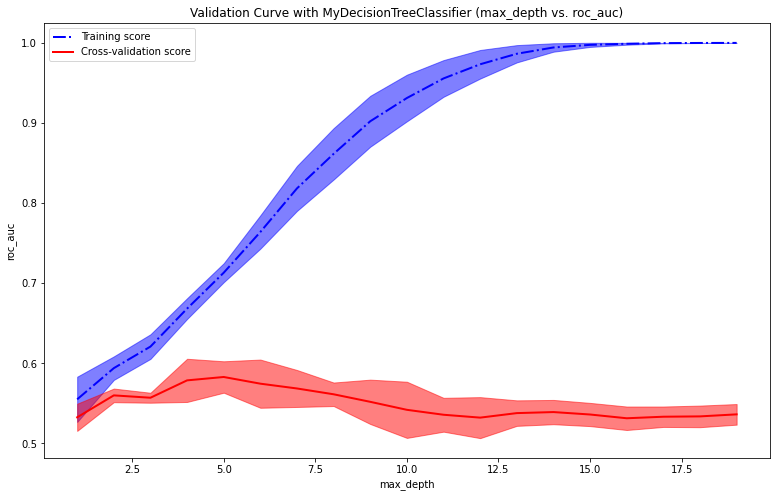

In [338]:
plt.figure(figsize=(13, 8))
train_score_mean = tree_train_scores.mean(axis=1)
train_score_std = tree_train_scores.std(axis=1)
valid_scores_mean = tree_valid_scores.mean(axis=1)
valid_scores_std = tree_valid_scores.std(axis=1)

plt.fill_between(param_range, train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(param_range, valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)


plt.plot(param_range, train_score_mean, c='b', linestyle='-.', lw=2, label="Training score")
plt.plot(param_range, valid_scores_mean, c='r', lw=2, label="Cross-validation score")


plt.xlabel('max_depth')
plt.ylabel('roc_auc')
plt.legend(loc="best")
plt.title("Validation Curve with MyDecisionTreeClassifier (max_depth vs. roc_auc)")

In [256]:
param_grid = {'max_depth': range(2, 13)}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
model = MyDecisionTreeClassifier(criterion='gini')
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=132)
gs = GridSearchCV(model,
                  param_grid=param_grid,
                  scoring=scoring, refit='AUC', return_train_score=True, n_jobs=-1, verbose=2)
gs.fit(X, y)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   31.2s finished


GridSearchCV(estimator=MyDecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(2, 13)}, refit='AUC',
             return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)},
             verbose=2)

In [257]:
results = gs.cv_results_

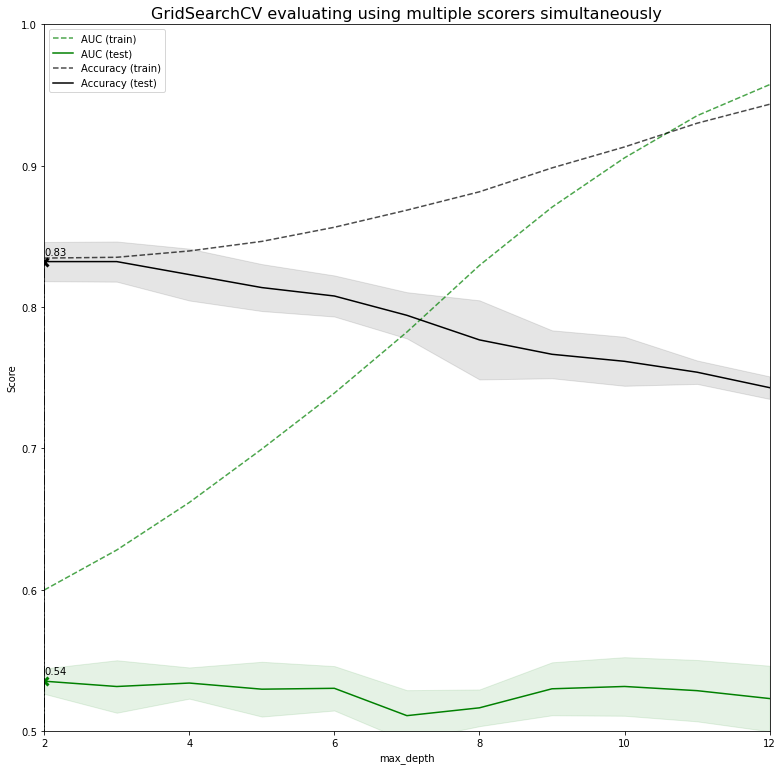

In [259]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("max_depth")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(2, 12)
ax.set_ylim(0.5, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

### Строим график зависимости roc_auc на валидации от минимального числа объектов для сплита:

In [339]:
model = MyDecisionTreeClassifier(criterion='gini')

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=132)

param_range = range(2, 9)
tree_train_scores, tree_valid_scores = validation_curve(model, X_train, y_train, 
                                              param_name='min_samples_split', param_range=param_range,
                                              cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:    2.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    3.5s finished


Text(0.5, 1.0, 'Validation Curve with MyDecisionTreeClassifier (min_samples_split vs. roc_auc)')

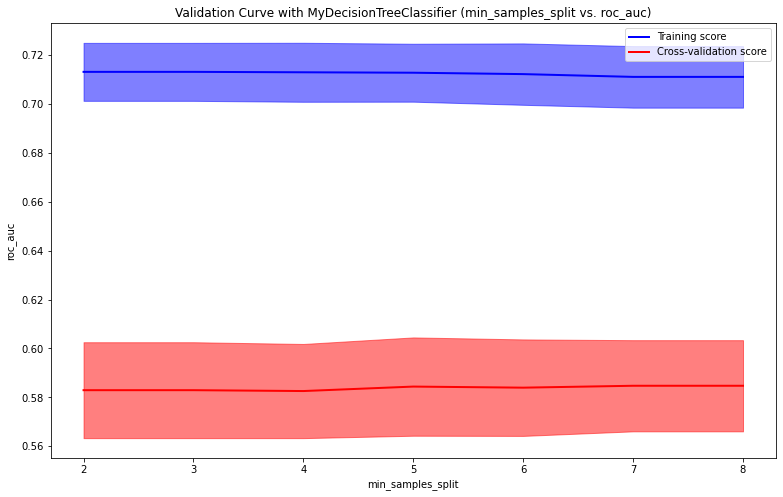

In [340]:
plt.figure(figsize=(13, 8))
train_score_mean = tree_train_scores.mean(axis=1)
train_score_std = tree_train_scores.std(axis=1)
valid_scores_mean = tree_valid_scores.mean(axis=1)
valid_scores_std = tree_valid_scores.std(axis=1)

plt.fill_between(param_range, train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(param_range, valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(param_range, train_score_mean, c='b', lw=2, label="Training score")
plt.plot(param_range, valid_scores_mean, c='r', lw=2, label="Cross-validation score")

plt.xlabel('min_samples_split')
plt.ylabel('roc_auc')
plt.legend(loc="best")
plt.title("Validation Curve with MyDecisionTreeClassifier (min_samples_split vs. roc_auc)")

### С помощью GridSearchCV подбираем criterion, max_depth, min_samples_split

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

In [317]:
param_grid = {'criterion': ['gini', 'entropy'],
    'max_depth': range(8, 13),
    'min_samples_split': range(2, 5)}

In [318]:
model = MyDecisionTreeClassifier()

In [319]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=132)

In [356]:
my_gs = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, 
                             cv=cv, scoring='roc_auc', verbose=10)

In [357]:
my_gs.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:  1.1min remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=132, shuffle=True),
             estimator=MyDecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(8, 13),
                         'min_samples_split': range(2, 5)},
             scoring='roc_auc', verbose=10)

In [358]:
my_gs.best_params_

{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 3}

In [359]:
my_gs.best_score_

0.5625914798864747

In [362]:
print(f"my_clf train accuracy_score = {accuracy_score(y_pred=my_gs.best_estimator_.predict(X_train), y_true=y_train)}")
print(f"my_clf test accuracy_score = {accuracy_score(y_pred=my_gs.best_estimator_.predict(X_test), y_true=y_test)}")

my_clf train accuracy_score = 0.8819875776397516
my_clf test accuracy_score = 0.7925465838509317


### Для сравнения подберем параметры для DecisionTreeClassifier из sklearn:

In [306]:
model = DecisionTreeClassifier()
gs = GridSearchCV(model, param_grid=param_grid, n_jobs=-1,
                  cv=cv, scoring='average_precision', verbose=10)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0710s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1650s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=132, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(8, 13),
                         'min_samples_split': range(2, 5)},
             scoring='average_precision', verbose=10)

In [352]:
print(f"clf test roc_auc_score = {roc_auc_score(y_test, gs.best_estimator_.predict_proba(X_test)[:, 1])}")

clf test roc_auc_score = 0.7989801365749495


#### Видим, что почти совпадают:

In [363]:
print(f"sklearn params: {gs.best_params_}")
print(f"my params: {my_gs.best_params_}")

sklearn params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2}
my params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 3}


### Итого на тестовой выборке удалось добиться точности (правильности):

In [354]:
print(f"my_clf test accuracy_score = {accuracy_score(y_pred=my_gs.best_estimator_.predict(X_test), y_true=y_test)}")
print(f"clf test accuracy_score = {accuracy_score(y_pred=gs.best_estimator_.predict(X_test), y_true=y_test)}")

my_clf test accuracy_score = 0.7925465838509317
clf test accuracy_score = 0.8782608695652174


In [361]:
print(f"my_clf test roc_auc_score = {roc_auc_score(y_test, my_gs.best_estimator_.predict_proba(X_test)[:, 1])}")
print(f"clf test roc_auc_score = {roc_auc_score(y_test, gs.best_estimator_.predict_proba(X_test)[:, 1])}")

my_clf test roc_auc_score = 0.5238060813666393
clf test roc_auc_score = 0.7989801365749495


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [327]:
best_model = my_gs.best_estimator_

In [328]:
best_model_sklearn = gs.best_estimator_

In [329]:
feature_importances = best_model.get_feature_importance()
feature_importances_sklearn = best_model_sklearn.feature_importances_

In [330]:
df_X = df_pair.drop(['match', 'iid', 'pid'], axis=1)

In [331]:
feature_importances_sorted = np.argsort(feature_importances)[::-1]
feature_importances_sorted_sklearn = np.argsort(feature_importances_sklearn)[::-1]
df_features = pd.DataFrame([
                            df_X.columns[feature_importances_sorted],
                            feature_importances[feature_importances_sorted],
                            ],
                            index = [ "feature", "feature importace"]).T

df_features_sklearn = pd.DataFrame([
                            df_X.columns[feature_importances_sorted_sklearn],
                            feature_importances_sklearn[feature_importances_sorted_sklearn],
                            ],
                            index = [ "feature", "feature importace"]).T
df_features.iloc[:10]

,feature,feature importace
0,int_corr,0.191268
1,age,0.149586
2,attr1_1,0.0872646
3,mn_sat_f,0.0538243
4,samerace,0.0418186
5,date_f,0.0411141
6,attr2_1,0.0401784
7,amb1_1_f,0.03777
8,attr1_1_f,0.0349628
9,amb1_1,0.0337549


In [332]:
df_features_sklearn.iloc[:10]

,feature,feature importace
0,fun1_1_f,0.0580231
1,int_corr,0.0532101
2,sinc1_1,0.0485357
3,fun2_1_f,0.0423847
4,attr2_1,0.0381041
5,intel2_1_f,0.0365445
6,intel1_1_f,0.0345577
7,sinc2_1_f,0.0333141
8,fun2_1,0.032264
9,shar1_1,0.0320943


Видим, что признаки частично совпали.

- int_corr - "Корреляция между интересами пар"
- age_f - возраст
- mn_sat_f - Средний балл по SAT для вуза, в котором учился
- imprace_f - "Насколько важно для вас (по шкале от 1 до 10), чтобы человек, с которым вы встречаетесь, принадлежал к той же расовой / этнической принадлежности?"
- shar1_1_f - "Имеет общие интересы / хобби."
- sinc1_1_f - "Искренность"

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

